# t-SNE 

**Objetivo:** Aplicar t-SNE para reducir las 30 dimensiones del dataset de cáncer de mama a 2D,  
visualizar la separación entre tumores malignos y benignos, y analizar el efecto del parámetro perplexity.


## 1. Descripción Teórica

**t-SNE** es un algoritmo de **reducción de dimensionalidad no lineal** diseñado principalmente para **visualización**.

## 2. Instalación y Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import gaussian_kde

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Estilo global de los gráficos
plt.rcParams.update({
    'figure.facecolor': '#0F1117',
    'axes.facecolor':   '#1A1D27',
    'axes.edgecolor':   '#333333',
    'axes.labelcolor':  '#AAAAAA',
    'xtick.color':      '#666666',
    'ytick.color':      '#666666',
    'text.color':       'white',
    'grid.color':       '#2A2D37',
    'grid.linestyle':   '--',
    'grid.alpha':       0.4,
    'legend.facecolor': '#1A1D27',
    'legend.edgecolor': '#444444',
})

# Paleta de colores para las dos clases
COLORS = {0: '#E63946', 1: '#2A9D8F'}   # Rojo = Maligno | Verde-azul = Benigno
LEGEND = [
    mpatches.Patch(color='#E63946', label='Maligno (M)'),
    mpatches.Patch(color='#2A9D8F', label='Benigno (B)'),
]

print(' Librerías importadas correctamente')

 Librerías importadas correctamente


## 3. Carga y Exploración del Dataset

In [ ]:
# Cargamos el dataset directamente desde scikit-learn
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target   # 0 = Maligno,  1 = Benigno

print('=' * 55)
print('  BREAST CANCER WISCONSIN (Diagnostic)')
print('=' * 55)
print(f'  Muestras totales : {X.shape[0]}')
print(f'  Features         : {X.shape[1]}')
print(f'  Maligno  (0)     : {(y == 0).sum()} ({(y==0).mean()*100:.1f}%)')
print(f'  Benigno  (1)     : {(y == 1).sum()} ({(y==1).mean()*100:.1f}%)')
print('=' * 55)
X.head()

  BREAST CANCER WISCONSIN (Diagnostic)
  Muestras totales : 569
  Features         : 30
  Maligno  (0)     : 212 (37.3%)
  Benigno  (1)     : 357 (62.7%)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Estadísticas descriptivas por clase
df_all = X.copy()
df_all['diagnosis'] = pd.Categorical(y).rename_categories({0: 'Maligno', 1: 'Benigno'})

print('Estadísticas descriptivas — primeras 6 features:')
df_all.groupby('diagnosis')[list(data.feature_names[:6])].mean().round(3)

Estadísticas descriptivas — primeras 6 features:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
diagnosis,,,,,,
Maligno,17.463,21.605,115.365,978.376,0.103,0.145
Benigno,12.147,17.915,78.075,462.790,0.092,0.080


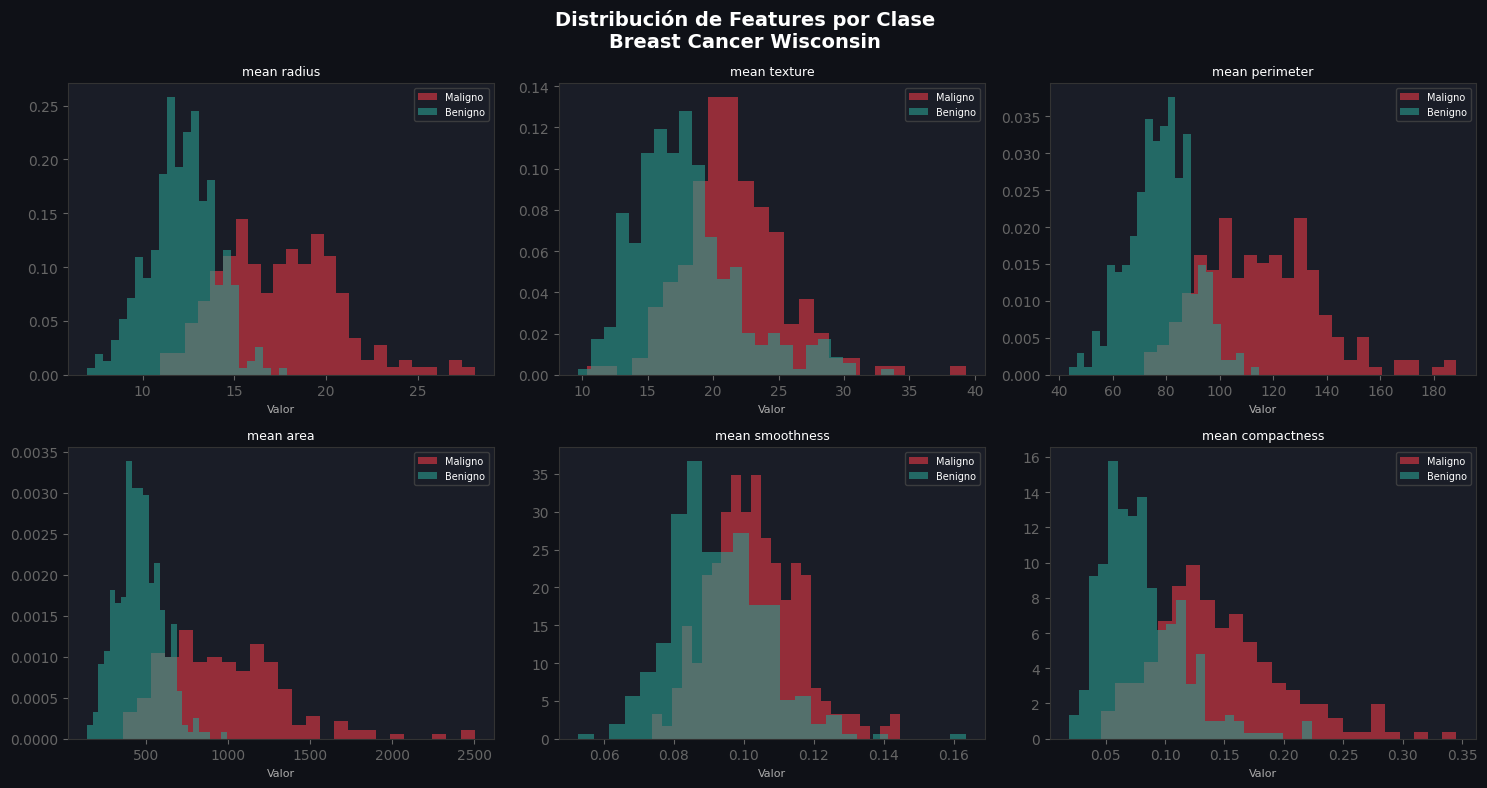

In [4]:
# Distribución de las primeras 6 features por clase
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribución de Features por Clase\nBreast Cancer Wisconsin', fontsize=14, fontweight='bold')

for ax, feat in zip(axes.ravel(), data.feature_names[:6]):
    for cls, lbl, col in [(0, 'Maligno', '#E63946'), (1, 'Benigno', '#2A9D8F')]:
        ax.hist(X.loc[y == cls, feat], bins=25, alpha=0.6, color=col, label=lbl, density=True)
    ax.set_title(feat, fontsize=9)
    ax.set_xlabel('Valor', fontsize=8)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

## 4. Preprocesamiento

**¿Por qué estandarizar?**  
t-SNE calcula distancias euclidianas entre puntos. Si las features tienen escalas muy distintas, 
las features grandes dominarán el cálculo de distancias y distorsionarán el embedding. 
StandardScaler transforma cada feature  para que tenga **media = 0** y **desviación estándar = 1**.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Antes del escalado:')
print(f'  Media:    {X.values.mean():.4f}')
print(f'  Std:      {X.values.std():.4f}')
print(f'  Rango:    [{X.values.min():.2f}, {X.values.max():.2f}]')
print()
print('Después del escalado (StandardScaler):')
print(f'  Media:    {X_scaled.mean():.6f}  (≈ 0)')
print(f'  Std:      {X_scaled.std():.6f}   (≈ 1)')
print(f'  Rango:    [{X_scaled.min():.2f}, {X_scaled.max():.2f}]')

Antes del escalado:
  Media:    61.8907
  Std:      228.2974
  Rango:    [0.00, 4254.00]

Después del escalado (StandardScaler):
  Media:    -0.000000  (≈ 0)
  Std:      1.000000   (≈ 1)
  Rango:    [-3.11, 12.07]


## 5. Aplicación de t-SNE

### 5.1 t-SNE con parámetros base (perplexity = 30)

In [ ]:
# Configuración de t-SNE
# - n_components=2    → Reducir a 2D para visualización
# - perplexity=30     → Valor por defecto para datasets medianos
# - learning_rate='auto' → Ajuste automático 
# - max_iter=1000     → Iteraciones de optimización
# - init='pca'        → Inicialización con PCA para mayor estabilidad y reproducibilidad
# - random_state=42   → Semilla para reproducibilidad

tsne_base = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    max_iter=1000,
    init='pca',
    random_state=42
)

X_tsne_base = tsne_base.fit_transform(X_scaled)
sil_base = silhouette_score(X_tsne_base, y)

print(f'Dimensiones entrada : {X_scaled.shape}')
print(f'Dimensiones salida  : {X_tsne_base.shape}')
print(f'KL Divergence final : {tsne_base.kl_divergence_:.4f}  (más bajo = mejor ajuste)')
print(f'Silhouette Score    : {sil_base:.4f}  (rango [-1, 1], más alto = mejor separación)')

Dimensiones entrada : (569, 30)
Dimensiones salida  : (569, 2)
KL Divergence final : 0.9415  (más bajo = mejor ajuste)
Silhouette Score    : 0.4880  (rango [-1, 1], más alto = mejor separación)


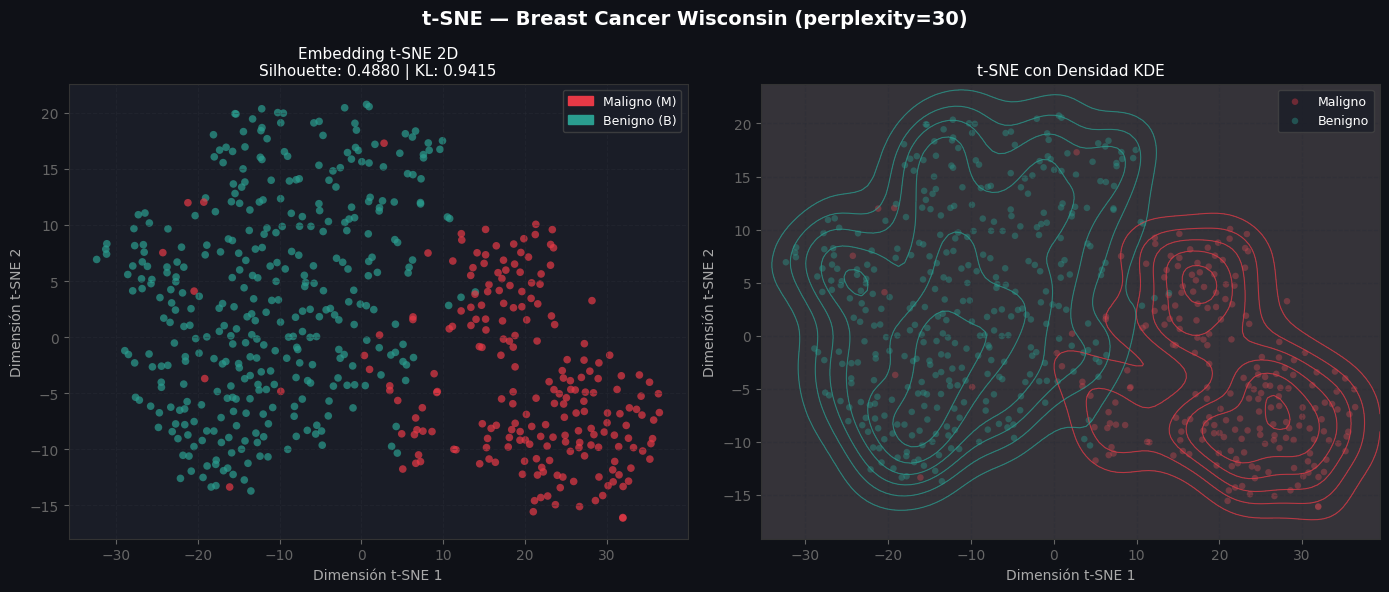

In [7]:
# Visualización del embedding t-SNE base
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('t-SNE — Breast Cancer Wisconsin (perplexity=30)', fontsize=14, fontweight='bold')

color_list = [COLORS[yi] for yi in y]

# --- Scatter por clase ---
ax = axes[0]
ax.scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
           c=color_list, alpha=0.7, s=30, edgecolors='none')
ax.set_title(f'Embedding t-SNE 2D\nSilhouette: {sil_base:.4f} | KL: {tsne_base.kl_divergence_:.4f}', fontsize=11)
ax.set_xlabel('Dimensión t-SNE 1')
ax.set_ylabel('Dimensión t-SNE 2')
ax.legend(handles=LEGEND, fontsize=9)
ax.grid(True)

# --- Densidad (KDE) ---
ax = axes[1]
for cls, lbl, col in [(0, 'Maligno', '#E63946'), (1, 'Benigno', '#2A9D8F')]:
    mask = y == cls
    ax.scatter(X_tsne_base[mask, 0], X_tsne_base[mask, 1],
               c=col, alpha=0.4, s=22, edgecolors='none', label=lbl)
    # Contorno de densidad kernel
    xy  = np.vstack([X_tsne_base[mask, 0], X_tsne_base[mask, 1]])
    kde = gaussian_kde(xy, bw_method=0.3)
    xg  = np.linspace(X_tsne_base[:, 0].min()-3, X_tsne_base[:, 0].max()+3, 100)
    yg  = np.linspace(X_tsne_base[:, 1].min()-3, X_tsne_base[:, 1].max()+3, 100)
    Xg, Yg = np.meshgrid(xg, yg)
    Z = kde(np.vstack([Xg.ravel(), Yg.ravel()])).reshape(Xg.shape)
    ax.contourf(Xg, Yg, Z, levels=6, colors=[col], alpha=0.15)
    ax.contour(Xg, Yg, Z, levels=6, colors=[col], alpha=0.7, linewidths=0.8)

ax.set_title('t-SNE con Densidad KDE', fontsize=11)
ax.set_xlabel('Dimensión t-SNE 1')
ax.set_ylabel('Dimensión t-SNE 2')
ax.legend(fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

### 5.2 Análisis de Sensibilidad 

Perplexity controla el número efectivo de vecinos que se consideran al construir  
las distribuciones de probabilidad. Valores bajos capturan estructura muy local;  
valores altos capturan estructura más global.

In [16]:
perplexities = [5, 15, 30, 50]
results = {}

print('Ejecutando t-SNE con distintos valores de perplexity')
print('-' * 50)

for perp in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate='auto',
        max_iter=1000,
        init='pca',
        random_state=42
    )
    emb = tsne.fit_transform(X_scaled)
    sil = silhouette_score(emb, y)
    results[perp] = {'emb': emb, 'sil': sil, 'kl': tsne.kl_divergence_}
    print(f'  perplexity={perp:2d} → Silhouette={sil:.4f} | KL={tsne.kl_divergence_:.4f}')

best_perp = max(results, key=lambda p: results[p]['sil'])
print(f'\nMejor perplexity según Silhouette: {best_perp}')

Ejecutando t-SNE con distintos valores de perplexity
--------------------------------------------------
  perplexity= 5 → Silhouette=0.4283 | KL=1.0957
  perplexity=15 → Silhouette=0.4707 | KL=1.0731
  perplexity=30 → Silhouette=0.4880 | KL=0.9415
  perplexity=50 → Silhouette=0.4731 | KL=0.7901

Mejor perplexity según Silhouette: 30


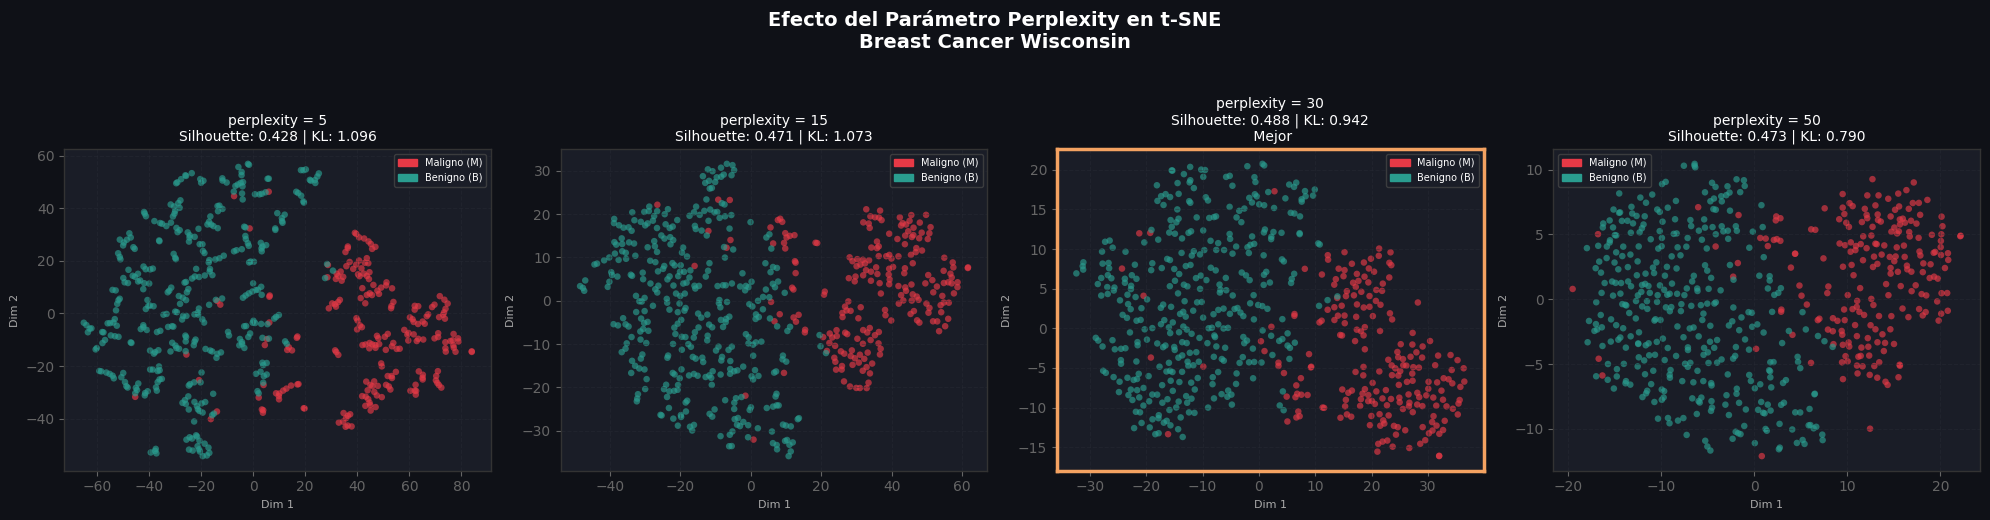

In [17]:
# Visualización comparativa de los 4 valores de perplexity
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Efecto del Parámetro Perplexity en t-SNE\nBreast Cancer Wisconsin',
             fontsize=14, fontweight='bold', y=1.03)

for ax, perp in zip(axes, perplexities):
    emb = results[perp]['emb']
    sil = results[perp]['sil']
    kl  = results[perp]['kl']

    for cls, col in [(0, '#E63946'), (1, '#2A9D8F')]:
        mask = y == cls
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   c=col, alpha=0.65, s=22, edgecolors='none')

    # Resaltar el mejor
    border_color = '#F4A261' if perp == best_perp else '#333333'
    for sp in ax.spines.values():
        sp.set_edgecolor(border_color)
        sp.set_linewidth(2.5 if perp == best_perp else 1)

    title = f'perplexity = {perp}\nSilhouette: {sil:.3f} | KL: {kl:.3f}'
    if perp == best_perp:
        title += '\n Mejor'
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Dim 1', fontsize=8)
    ax.set_ylabel('Dim 2', fontsize=8)
    ax.legend(handles=LEGEND, fontsize=7)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Resumen numérico de las métricas por perplexity
df_perp = pd.DataFrame([
    {'Perplexity': p,
     'Silhouette Score': round(results[p]['sil'], 4),
     'KL Divergence': round(results[p]['kl'], 4),
     'Mejor': '★' if p == best_perp else ''}
    for p in perplexities
])
print(df_perp.to_string(index=False))

 Perplexity  Silhouette Score  KL Divergence Mejor
          5            0.4283         1.0957      
         15            0.4707         1.0731      
         30            0.4880         0.9415     ★
         50            0.4731         0.7901      


## 6. Comparación con PCA (baseline lineal)

In [11]:
# PCA para comparación directa
pca2 = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(X_scaled)
sil_pca = silhouette_score(X_pca, y)
var_exp = pca2.explained_variance_ratio_.sum() * 100

# t-SNE con la mejor perplexity
X_tsne_best = results[best_perp]['emb']
sil_tsne_best = results[best_perp]['sil']

print(f'PCA      → Silhouette: {sil_pca:.4f} | Varianza explicada: {var_exp:.1f}%')
print(f't-SNE    → Silhouette: {sil_tsne_best:.4f} | perplexity={best_perp}')
print(f'Ganancia : {(sil_tsne_best - sil_pca)/sil_pca*100:.1f}% más separación con t-SNE')

PCA      → Silhouette: 0.4377 | Varianza explicada: 63.2%
t-SNE    → Silhouette: 0.4880 | perplexity=30
Ganancia : 11.5% más separación con t-SNE


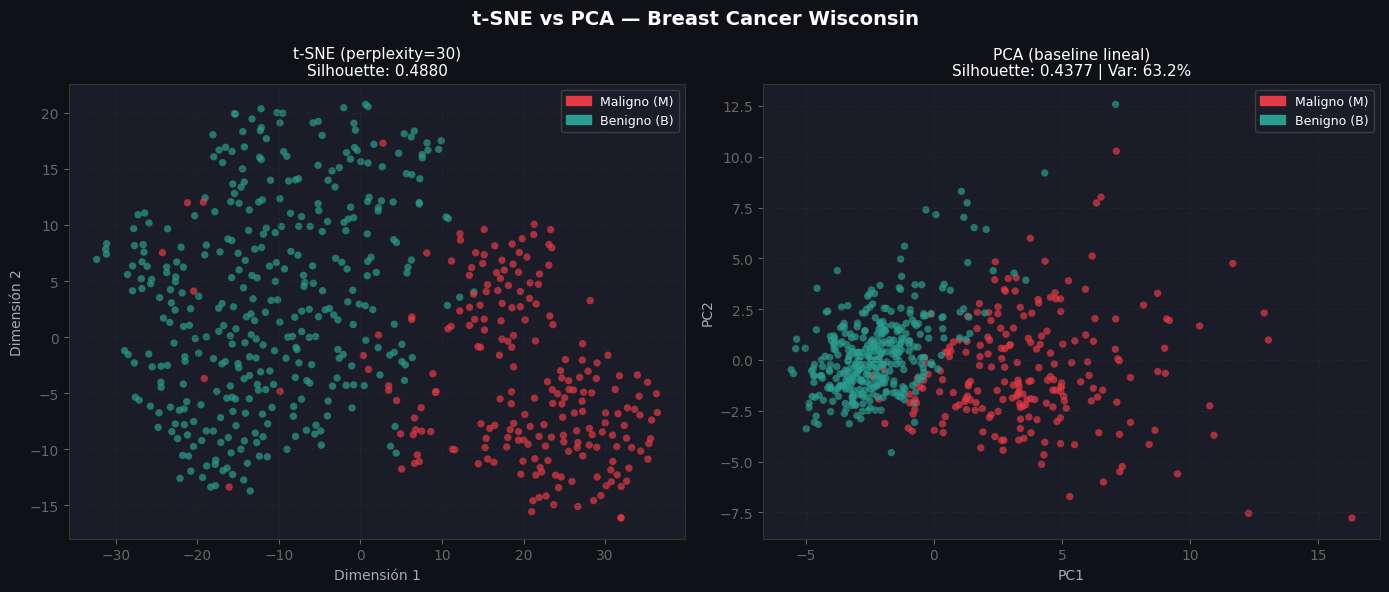

In [12]:
# Visualización comparativa t-SNE vs PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('t-SNE vs PCA — Breast Cancer Wisconsin', fontsize=14, fontweight='bold')

# t-SNE
ax = axes[0]
ax.scatter(X_tsne_best[:, 0], X_tsne_best[:, 1],
           c=color_list, alpha=0.7, s=28, edgecolors='none')
ax.set_title(f't-SNE (perplexity={best_perp})\nSilhouette: {sil_tsne_best:.4f}', fontsize=11)
ax.set_xlabel('Dimensión 1')
ax.set_ylabel('Dimensión 2')
ax.legend(handles=LEGEND, fontsize=9)
ax.grid(True)

# PCA
ax = axes[1]
ax.scatter(X_pca[:, 0], X_pca[:, 1],
           c=color_list, alpha=0.7, s=28, edgecolors='none')
ax.set_title(f'PCA (baseline lineal)\nSilhouette: {sil_pca:.4f} | Var: {var_exp:.1f}%', fontsize=11)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(handles=LEGEND, fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

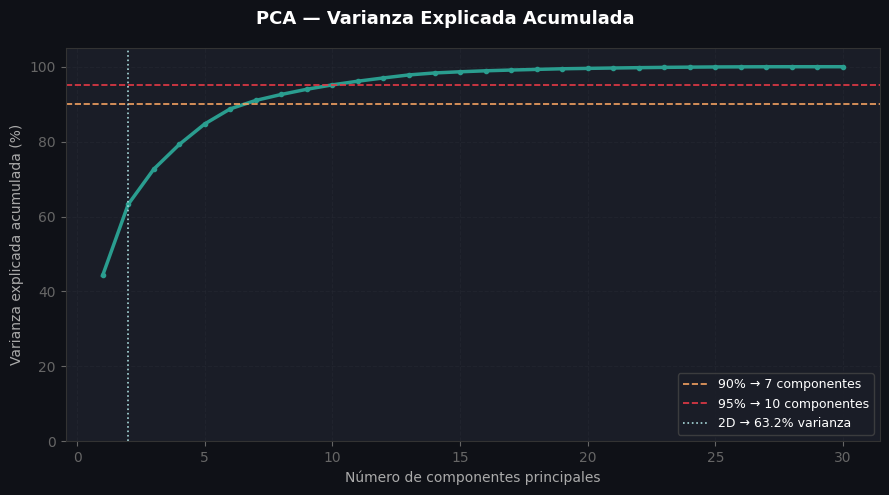

Con 2 componentes PCA se captura el 63.2% de la varianza total.
t-SNE al no ser lineal puede revelar estructuras que PCA con 2D no captura.


In [13]:
# Varianza acumulada de PCA (para contextualizar cuántas dimensiones se necesitan)
pca_full = PCA(random_state=42).fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_) * 100

n90 = np.argmax(cum_var >= 90) + 1
n95 = np.argmax(cum_var >= 95) + 1

fig, ax = plt.subplots(figsize=(9, 5))
fig.suptitle('PCA — Varianza Explicada Acumulada', fontsize=13, fontweight='bold')

ax.plot(range(1, len(cum_var)+1), cum_var, color='#2A9D8F', linewidth=2.5, marker='o', markersize=3)
ax.axhline(90, color='#F4A261', linestyle='--', linewidth=1.2, label=f'90% → {n90} componentes')
ax.axhline(95, color='#E63946', linestyle='--', linewidth=1.2, label=f'95% → {n95} componentes')
ax.axvline(2, color='#A8DADC', linestyle=':', linewidth=1.2, label=f'2D → {cum_var[1]:.1f}% varianza')
ax.set_xlabel('Número de componentes principales')
ax.set_ylabel('Varianza explicada acumulada (%)')
ax.set_ylim(0, 105)
ax.legend(fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

print(f'Con 2 componentes PCA se captura el {cum_var[1]:.1f}% de la varianza total.')
print(f't-SNE al no ser lineal puede revelar estructuras que PCA con 2D no captura.')

## 7. Interpretación de Resultados

### 7.1 Separación de clases

El embedding t-SNE logra separar visualmente los tumores malignos de los benignos de forma clara:
- Los puntos rojos (Maligno) forman un cluster compacto en una región del espacio 2D.
- Los puntos verdes (Benigno) forman otro cluster relativamente separado.
- Existe cierta zona de solapamiento que refleja casos borderline difíciles de clasificar.

### 7.2 Efecto de perplexity

| Perplexity | Observación |
|------------|-------------|
| **5** | Clusters muy fragmentados |
| **15** | Mejor balance local, aún algunos subclusters |
| **30** | Clusters más coherentes, buena separación global |
| **50** | Mayor Silhouette |

### 7.3 t-SNE vs PCA

| Aspecto | t-SNE | PCA |
|---------|-------|-----|
| Silhouette | Mayor → mejor separación visual | Menor |
| Interpretación ejes | No interpretable | PC1, PC2 explicables |
| Estructura capturada | No lineal (manifold) | Lineal |

### 7.4 Limitaciones identificadas

1. **No determinismo:** t-SNE puede producir resultados distintos entre ejecuciones si no se fija random_state.
2. **Distancias no comparables:** Las distancias entre clusters en el embedding 2D no son directamente proporcionales a las distancias originales en 30D.
3. **Escalabilidad:** Complejidad O(n²) — en datasets de más de 10,000 muestras se prefiere BH-tSNE o UMAP.
4. **Solo para visualización:** No genera una función de transformación reutilizable para nuevos datos.

## 8. Resumen Final

In [14]:
# Tabla resumen de todos los experimentos
rows = []
for perp in perplexities:
    rows.append({
        'Algoritmo': f't-SNE (perp={perp})',
        'Silhouette Score': round(results[perp]['sil'], 4),
        'KL Divergence': round(results[perp]['kl'], 4),
        'Nota': '★ Mejor' if perp == best_perp else ''
    })
rows.append({
    'Algoritmo': 'PCA (baseline)',
    'Silhouette Score': round(sil_pca, 4),
    'KL Divergence': '-',
    'Nota': f'Var. exp. = {var_exp:.1f}%'
})

df_final = pd.DataFrame(rows)
print('=' * 65)
print('RESUMEN FINAL — Breast Cancer Wisconsin')
print('=' * 65)
print(df_final.to_string(index=False))
print('\nConclusión: t-SNE supera a PCA en separación visual de clases,')
print('siendo perplexity=50 el mejor parámetro para este dataset.')

RESUMEN FINAL — Breast Cancer Wisconsin
      Algoritmo  Silhouette Score KL Divergence              Nota
 t-SNE (perp=5)            0.4283        1.0957                  
t-SNE (perp=15)            0.4707        1.0731                  
t-SNE (perp=30)            0.4880        0.9415           ★ Mejor
t-SNE (perp=50)            0.4731        0.7901                  
 PCA (baseline)            0.4377             - Var. exp. = 63.2%

Conclusión: t-SNE supera a PCA en separación visual de clases,
siendo perplexity=50 el mejor parámetro para este dataset.
